# Model training

By now, we have obtained an improved dataset by introduction of more near-boundary points. We first try to train a neural network to see how the model will perform when classifying near-boundary points.

In [264]:
import numpy as np
import math
import pandas as pd

import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

We form the training set and test set as follows: We take out 80% of datapoints from the uniformly drawn dataset and the near-boundary dataset to form the training set. We use the remaining 20% as the test set.

In [265]:
## Load the dataset
class LorenzDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features = torch.tensor([self.data.iloc[idx].x0, self.data.iloc[idx].y0, self.data.iloc[idx].z0]).float()
        label = torch.tensor(self.data.iloc[idx].attracted).float()
        return features, label
    
dataset_uniform = LorenzDataset("dataset_large.csv")
dataset_near = LorenzDataset("dataset_near.csv")

dataset_uniform_train, dataset_uniform_test = torch.utils.data.random_split(dataset_uniform, [80000, 20000])
dataset_near_train, dataset_near_test = torch.utils.data.random_split(dataset_near, [16000, 4000])
dataset_train = torch.utils.data.ConcatDataset([dataset_uniform_train, dataset_near_train])

dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_near_test = DataLoader(dataset_near_test, batch_size=32, shuffle=True)
dataloader_uniform_test = DataLoader(dataset_uniform_test, batch_size=32, shuffle=True)



In [266]:
## Define the neural network. The complexity of the network is a hyperparameter.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3,128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x
    
net = Net()

In [267]:
## Set up loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [268]:
# Check if MPS is available and set the device accordingly
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [269]:
# Move the model to the device
net = net.to(device)
criterion = criterion.to(device)

# Train the network
for epoch in range(1000):  # loop over the dataset multiple times
    running_loss = 0.0
    mini_batch_count = 0
    for features, labels in dataloader_train:  # use the DataLoader here
        # Convert labels from -1 or 1 to 0 or 1
        labels = ((labels + 1) / 2).float()

        # Reshape labels to match the output shape
        labels = labels.view(-1)

        # Move the features and labels to the device
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(features).view(-1) 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        mini_batch_count += 1

    print('Finished training for epoch %d, loss: %.3f' % (epoch + 1, running_loss / mini_batch_count))

Finished training for epoch 1, loss: 0.660
Finished training for epoch 2, loss: 0.632
Finished training for epoch 3, loss: 0.574
Finished training for epoch 4, loss: 0.452
Finished training for epoch 5, loss: 0.373
Finished training for epoch 6, loss: 0.338
Finished training for epoch 7, loss: 0.320
Finished training for epoch 8, loss: 0.300
Finished training for epoch 9, loss: 0.292
Finished training for epoch 10, loss: 0.282
Finished training for epoch 11, loss: 0.276
Finished training for epoch 12, loss: 0.272
Finished training for epoch 13, loss: 0.268
Finished training for epoch 14, loss: 0.263
Finished training for epoch 15, loss: 0.261
Finished training for epoch 16, loss: 0.254
Finished training for epoch 17, loss: 0.255
Finished training for epoch 18, loss: 0.255
Finished training for epoch 19, loss: 0.250
Finished training for epoch 20, loss: 0.248
Finished training for epoch 21, loss: 0.248
Finished training for epoch 22, loss: 0.244
Finished training for epoch 23, loss: 0.2

Accuracy: 0.9761999845504761


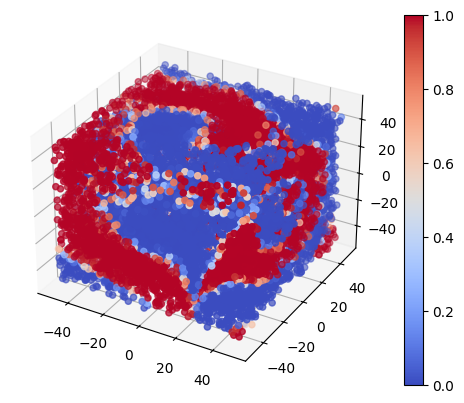

In [270]:
## Test the network and plot the results
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

features_list_uniform = []
labels_list_uniform = []
probability_list_uniform = []
predictions_list_uniform = []
acc = Accuracy(task = 'binary')


with torch.no_grad():
    for features, labels in dataloader_uniform_test:
        features = features.to(device)
        labels = labels.to(device)
        labels = ((labels + 1) / 2).float()
        probability = net(features)
        outputs = (probability >= 0.5).float()
        outputs = outputs.squeeze()

        acc.update(outputs, labels)

        # Move features, labels, and outputs to CPU and convert them to numpy arrays
        features_list_uniform.append(features.cpu().numpy())
        labels_list_uniform.append(labels.cpu().numpy())
        probability_list_uniform.append(probability.cpu().numpy())
        predictions_list_uniform.append(outputs.cpu().numpy())
accuracy = acc.compute()
print(f'Accuracy: {accuracy}')

# Concatenate all batches
features_uniform = np.concatenate(features_list_uniform, axis=0)
labels_uniform = np.concatenate(labels_list_uniform, axis=0)
probability_uniform = np.concatenate(probability_list_uniform, axis=0)
predictions_uniform = np.concatenate(predictions_list_uniform, axis=0)

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the features colored by the predictions
scatter = ax.scatter(features_uniform[:, 0], features_uniform[:, 1], features_uniform[:, 2], c=probability_uniform, cmap='coolwarm')

# Add a color bar
plt.colorbar(scatter)

plt.show()

Accuracy: 0.4737499952316284


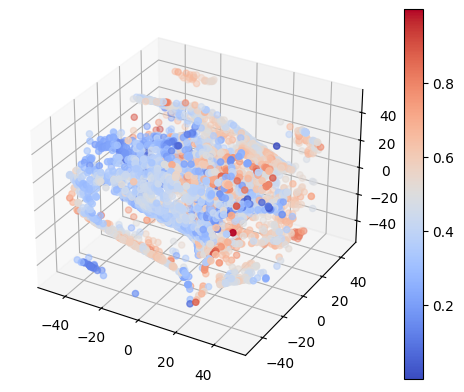

In [271]:
features_list_near = []
labels_list_near = []
probability_list_near = []
predictions_list_near = []
acc = Accuracy(task = 'binary')

dataloader_test = dataloader_near_test

with torch.no_grad():
    for features, labels in dataloader_test:
        features = features.to(device)
        labels = labels.to(device)
        labels = ((labels + 1) / 2).float()
        probability = net(features)
        outputs = (probability >= 0.5).float()
        outputs = outputs.squeeze()

        acc.update(outputs, labels)

        # Move features, labels, and outputs to CPU and convert them to numpy arrays
        features_list_near.append(features.cpu().numpy())
        labels_list_near.append(labels.cpu().numpy())
        probability_list_near.append(probability.cpu().numpy())
        predictions_list_near.append(outputs.cpu().numpy())
accuracy = acc.compute()
print(f'Accuracy: {accuracy}')

# Concatenate all batches
features_near = np.concatenate(features_list_near, axis=0)
labels_near = np.concatenate(labels_list_near, axis=0)
probability_near = np.concatenate(probability_list_near, axis=0)
predictions_near = np.concatenate(predictions_list_near, axis=0)

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the features colored by the predictions
scatter = ax.scatter(features_near[:, 0], features_near[:, 1], features_near[:, 2], c=probability_near, cmap='coolwarm')

# Add a color bar
plt.colorbar(scatter)

plt.show()

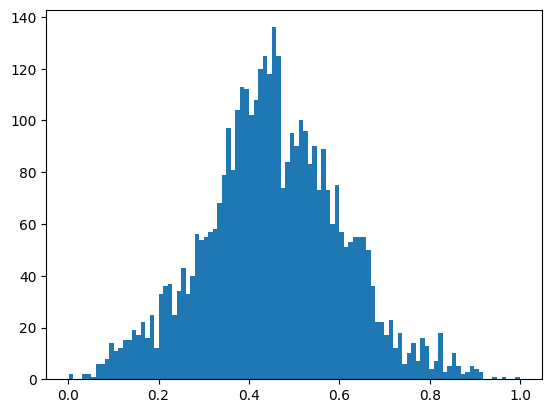

In [272]:
import matplotlib.pyplot as plt
plt.hist(probability_near, bins=100)
plt.show()

We could see that despite adding more near-boundary points when training the model, the performance does not improve at near-boundary points. We try to improve our model by defining an extra term to include in our loss function.

## Improvement of loss function

Note that when we trained a neural network $f$, the estimation of basin boundary would be the level set $f(\mathbf{x})=0$. Note that $b(\mathbf{x})$ is tangent to the boundary at any point $x$ along the boundary, thus normal to the gradient vector $\nabla f(\mathbf{x})$, and we could check this behavior by checking whether $\nabla f(\mathbf{x})^{T}b(\mathbf{x})=0$. We add an penalty term if this is not satified at boundary. Such a penalty is equilvalent to require that when $\mathbf{x}$ is close to boundary, $\lvert \nabla f(\mathbf{x})^{T}b(\mathbf{x})\rvert$ should be something small, say $<\delta$, where $\delta$ is a hyperparameter. We could therefore define our loss function as 
$$l(f)+\lambda\sum_{f(\mathbf{x})\approx 0}(\nabla f(\mathbf{x})^{T}b(\mathbf{x}))^{2}$$
where $l$ is the logistic loss to penalize error in classification, $\lambda$ is a hyperparameter to control how much we want to penalize such violation. We square the inner product to prevent errors of opposite signs from cancelling each other. Note that we are interested in angular violation, thus before we compute $\nabla f(\mathbf{x})^{T}b(\mathbf{x})$ we should normalize both vectors.

We implement the loss function as follows:
$$l(f)+\lambda\sum_{\mathbf{x}}\mathbb{I}(f(\mathbf{x})\approx 0)(\nabla f(\mathbf{x})^{T}b(\mathbf{x}))^{2}$$

In [307]:
class CustomLoss(nn.Module):
    def __init__(self, magnitude, threshold):
        super(CustomLoss, self).__init__()
        self.magnitude = magnitude
        self.threshold = threshold

    def forward(self, predictions, labels, inputs, b):
        l = nn.BCELoss()
        l = l(predictions.squeeze(), labels)

        near_condition = (predictions > 0.5 - self.threshold) & (predictions < 0.5 + self.threshold)
        near_points_prediction = predictions[near_condition]
        near_points_input = inputs[near_condition].clone().detach().requires_grad_(True)
        grads = torch.autograd.grad(near_points_prediction.sum(), near_points_input, create_graph=True, allow_unused=True)[0]
        
        if grads is not None:
            norm_grads = grads / grads.norm(dim = 1, keepdim=True)
            norm_b = b / b.norm(dim=1, keepdim=True)
            inner_product = (norm_grads * norm_b).sum(dim=1)
            inner_product = inner_product ** 2
            l += self.magnitude * inner_product
        
        return l

In [308]:
## Prepare the dataset
dataset_near = LorenzDataset("dataset_near.csv")
dataset_uniform = LorenzDataset("dataset_large.csv")

dataset_near_train, dataset_near_test = torch.utils.data.random_split(dataset_near, [16000, 4000])
dataset_uniform_train, dataset_uniform_test = torch.utils.data.random_split(dataset_uniform, [80000, 20000])

dataset_train = torch.utils.data.ConcatDataset([dataset_near_train, dataset_uniform_train])
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_near_test = DataLoader(dataset_near_test, batch_size=32, shuffle=True)
dataloader_uniform_test = DataLoader(dataset_uniform_test, batch_size=32, shuffle=True)



In [309]:
# Lorenz parameters.
sigma, beta, r = 10, 8/3, 10

In [310]:
def lorenz(t, X, sigma=10, beta=8/3, r=10):
    """The Lorenz equations."""
    x, y, z = X
    xp = sigma*(y - x)
    yp = r*x - y - x*z
    zp = -beta*z + x*y
    return xp, yp, zp

In [311]:
## Train the network with the custom loss function
net_customloss = Net()
criterion_customloss = CustomLoss(1, 100)
optimizer_customloss = optim.Adam(net_customloss.parameters(), lr=0.001)

In [312]:
# Move the model to the device
net_customloss = net_customloss.to(device)
criterion_customloss = criterion_customloss.to(device)

# Train the network
for epoch in range(100):  # loop over the dataset multiple times
    for batch in dataloader_train:
        features, labels = batch
        features = features.to(device)
        labels = labels.to(device)
        indicators = indicators.to(device)
        labels = ((labels + 1) / 2).float()
        probability = net_customloss(features).view(-1)
        loss = criterion_customloss(probability, labels, features, lorenz(0, features.T))
        optimizer_customloss.zero_grad()
        loss.backward()
        optimizer_customloss.step()
    print('Finished training for epoch %d, loss: %.3f' % (epoch + 1, loss.item()))

Finished training for epoch 1, loss: 0.728
Finished training for epoch 2, loss: 0.546
Finished training for epoch 3, loss: 0.394
Finished training for epoch 4, loss: 0.416
Finished training for epoch 5, loss: 0.271
Finished training for epoch 6, loss: 0.353
Finished training for epoch 7, loss: 0.327
Finished training for epoch 8, loss: 0.258
Finished training for epoch 9, loss: 0.250
Finished training for epoch 10, loss: 0.249
Finished training for epoch 11, loss: 0.105
Finished training for epoch 12, loss: 0.231
Finished training for epoch 13, loss: 0.356
Finished training for epoch 14, loss: 0.202
Finished training for epoch 15, loss: 0.236
Finished training for epoch 16, loss: 0.212
Finished training for epoch 17, loss: 0.182
Finished training for epoch 18, loss: 0.266
Finished training for epoch 19, loss: 0.364
Finished training for epoch 20, loss: 0.347
Finished training for epoch 21, loss: 0.273
Finished training for epoch 22, loss: 0.311
Finished training for epoch 23, loss: 0.3

Accuracy: 0.9796000123023987


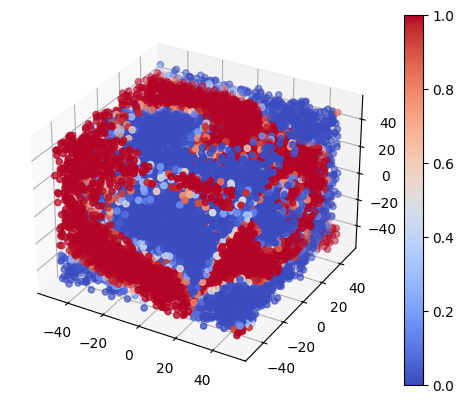

In [313]:
## Test the network and plot the results
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

features_list_uniform = []
labels_list_uniform = []
probability_list_uniform = []
predictions_list_uniform = []
acc = Accuracy(task = 'binary')


with torch.no_grad():
    for features, labels in dataloader_uniform_test:
        features = features.to(device)
        labels = labels.to(device)
        labels = ((labels + 1) / 2).float()
        probability = net(features)
        outputs = (probability >= 0.5).float()
        outputs = outputs.squeeze()

        acc.update(outputs, labels)

        # Move features, labels, and outputs to CPU and convert them to numpy arrays
        features_list_uniform.append(features.cpu().numpy())
        labels_list_uniform.append(labels.cpu().numpy())
        probability_list_uniform.append(probability.cpu().numpy())
        predictions_list_uniform.append(outputs.cpu().numpy())
accuracy = acc.compute()
print(f'Accuracy: {accuracy}')

# Concatenate all batches
features_uniform = np.concatenate(features_list_uniform, axis=0)
labels_uniform = np.concatenate(labels_list_uniform, axis=0)
probability_uniform = np.concatenate(probability_list_uniform, axis=0)
predictions_uniform = np.concatenate(predictions_list_uniform, axis=0)

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the features colored by the predictions
scatter = ax.scatter(features_uniform[:, 0], features_uniform[:, 1], features_uniform[:, 2], c=probability_uniform, cmap='coolwarm')

# Add a color bar
plt.colorbar(scatter)

plt.show()

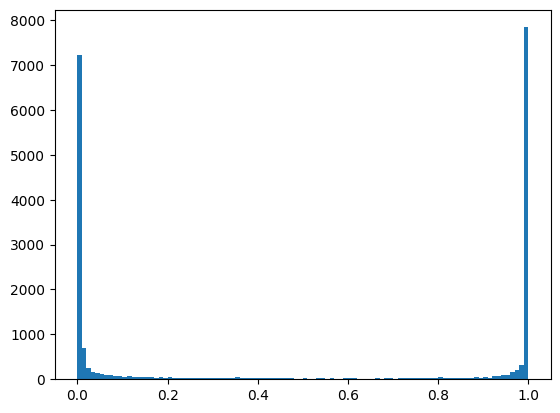

In [314]:
import matplotlib.pyplot as plt
plt.hist(probability_uniform, bins=100)
plt.show()

Accuracy: 0.5102499723434448


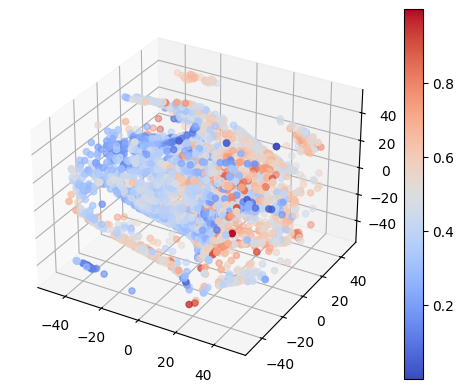

In [315]:
features_list_near = []
labels_list_near = []
probability_list_near = []
predictions_list_near = []
acc = Accuracy(task = 'binary')

dataloader_test = dataloader_near_test

with torch.no_grad():
    for features, labels in dataloader_test:
        features = features.to(device)
        labels = labels.to(device)
        labels = ((labels + 1) / 2).float()
        probability = net(features)
        outputs = (probability >= 0.5).float()
        outputs = outputs.squeeze()

        acc.update(outputs, labels)

        # Move features, labels, and outputs to CPU and convert them to numpy arrays
        features_list_near.append(features.cpu().numpy())
        labels_list_near.append(labels.cpu().numpy())
        probability_list_near.append(probability.cpu().numpy())
        predictions_list_near.append(outputs.cpu().numpy())
accuracy = acc.compute()
print(f'Accuracy: {accuracy}')

# Concatenate all batches
features_near = np.concatenate(features_list_near, axis=0)
labels_near = np.concatenate(labels_list_near, axis=0)
probability_near = np.concatenate(probability_list_near, axis=0)
predictions_near = np.concatenate(predictions_list_near, axis=0)

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the features colored by the predictions
scatter = ax.scatter(features_near[:, 0], features_near[:, 1], features_near[:, 2], c=probability_near, cmap='coolwarm')

# Add a color bar
plt.colorbar(scatter)

plt.show()

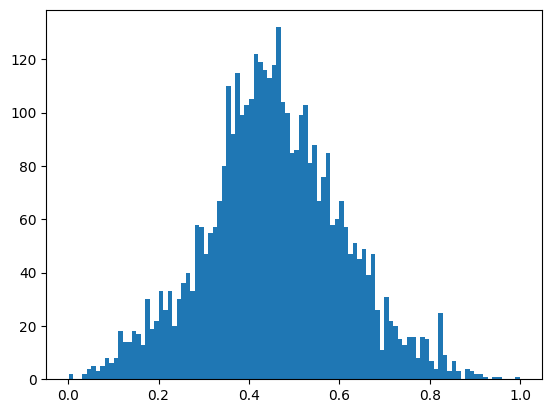

In [316]:
import matplotlib.pyplot as plt
plt.hist(probability_near, bins=100)
plt.show()